# Bayesian model fitting made easy with Variational Bayesian Monte Carlo (PyVBMC)

#### Tutorial for the Center for Neural Science, NYU - Jan 2023
#### [Luigi Acerbi](http://luigiacerbi.com/) (2023)

Tutorial on Bayesian inference for model fitting using the [PyVBMC package](https://github.com/acerbilab/pyvbmc). 

### THIS TUTORIAL NOTEBOOK IS WORK IN PROGRESS AND SOME PARTS MIGHT CHANGE. PLEASE  DOWNLOAD THE FINAL VERSION JUST BEFORE THE START OF THE TUTORIAL SESSION.



#### Instructions:

- To run the tutorial, you will need a standard scientific Python 3.x installation with Jupyter notebook (such as [Anaconda](https://www.anaconda.com/distribution/)).
- You will also need the [PyVBMC inference algorithm](https://github.com/acerbilab/pyvbmc). Just follow the installation instructions (often as simple as `pip install pyvbmc`).

## Initial setup and loading the data

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
from scipy.stats import norm

During this tutorial, we are going to use data from the [International Brain Laboratory](https://www.internationalbrainlab.com/) publicly released behavioral mouse dataset, from exemplar mouse `KS014`. See [The IBL et al. (2021)](https://elifesciences.org/articles/63711) for more information about the task and datasets. 

These data can also be inspected via the IBL DataJoint public interface [here](https://data.internationalbrainlab.org/mouse/18a54f60-534b-4ed5-8bda-b434079b8ab8).

For convenience, the data of all behavioral sessions from examplar mouse `KS014` have been already downloaded in the `data` folder and preprocessed into a `.csv` file. In this tutorial, we will only work with data from the training sessions (`KS014_train.csv`).

In [2]:
df = pd.read_csv('./data/KS014_train.csv')              # Load .csv file into a pandas DataFrame

df['signed_contrast'] = df['contrast']*df['position']   # We define a new column for "signed contrasts"
df.drop(columns='stim_probability_left', inplace=True)  # Stimulus probability has no meaning for training sessions

print('Total # of trials: ' + str(len(df['trial_num'])))
print('Sessions: ' + str(np.unique(df['session_num'])))
df.head()

Total # of trials: 10310
Sessions: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


,trial_num,session_num,contrast,position,response_choice,trial_correct,reaction_time,signed_contrast
0,1,1,100.0,-1.0,-1,1.0,1.052300,-100.0
1,2,1,50.0,1.0,1,1.0,0.276001,50.0
2,3,1,50.0,1.0,-1,0.0,2.094101,50.0
3,4,1,50.0,-1.0,1,0.0,3.407901,-50.0
4,5,1,50.0,1.0,1,1.0,1.601400,50.0


## I: Inspecting the data

The first thing to do with any dataset is to get familiar with it by running simple visualizations. Just plot stuff!  
Here we plot data from individual sessions. What can we see from here?

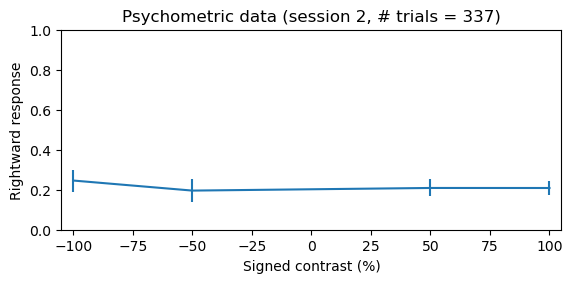

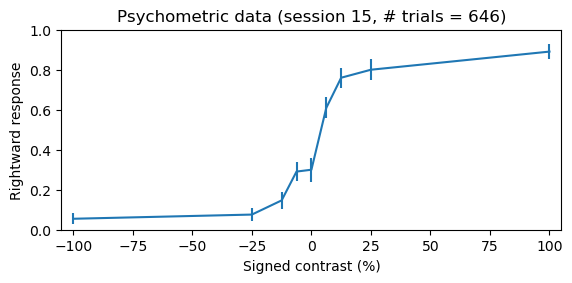

In [3]:
def plot_psychometric_data(df,session_num=None,ax=None):
    """Plot psychometric data (optionally, of a chosen training session) as a scatter plot."""
    
    if session_num == None:
        trial_mask = np.ones(len(df['session_num']), dtype=bool) # Select all trials
    else:
        trial_mask = df['session_num'] == session_num # Indexes of trials of the chosen session
    Ntrials = np.sum(trial_mask) # Number of chosen trials
        
    # Count "left" and "right" responses for each signed contrast level
    left_resp = df[(df['response_choice'] == -1) & trial_mask].groupby(['signed_contrast']).count()['trial_num']
    right_resp = df[(df['response_choice'] == 1) & trial_mask].groupby(['signed_contrast']).count()['trial_num']    
    
    frac_resp = right_resp / (left_resp + right_resp)
    err_bar = np.sqrt(frac_resp*(1-frac_resp)/(left_resp + right_resp)) # Why this formula for error bars?
    
    if ax == None:
        ax=fig.add_axes([0,0,1,1])
    ax.errorbar(x=left_resp.index,y=frac_resp,yerr=err_bar,label='data');
    ax.set_xlabel('Signed contrast (%)')
    ax.set_ylabel('Rightward response')
    if session_num == None:
        ax.set_title('Psychometric data (# trials = ' + str(Ntrials) + ')')        
    else:
        ax.set_title('Psychometric data (session ' + str(session_num) + ', # trials = ' + str(Ntrials) + ')')        
    plt.xlim((-105,105))
    plt.ylim((0,1))
    return ax

figsize = (5, 2) # Define standard figure size

fig = plt.figure(figsize=figsize)
plot_psychometric_data(df,2)
plt.show()

fig = plt.figure(figsize=figsize)
plot_psychometric_data(df,15)
plt.show()

## II. Psychometric function model

We define now the basic psychometric function (descriptive) model and a plotting function. The psychometric model is defined as:

$$p(\text{rightward choice} | s, \theta) = \lambda \gamma + (1 - \lambda) \cdot \Phi(s; \mu, \sigma)$$

where $\Phi(\cdot)$ is the cumulative distribution function (cdf) of a normal distribution and $s$ is the stimulus intensity (here, stimulus contrast, from -100 to 100).

The model parameters are $\theta = (\mu, \sigma, \lambda, \gamma)$.

In [4]:
def psychofun(theta,stim):
    """Psychometric function based on normal CDF and lapses."""
    mu = theta[0]          # bias
    sigma = theta[1]       # slope/noise
    lapse = theta[2]       # lapse rate
    if len(theta) == 4:    # lapse bias
        lapse_bias = theta[3];
    else:
        lapse_bias = 0.5   # if theta has only three elements, assume symmetric lapses
    
    p_right = norm.cdf(stim,loc=mu,scale=sigma)    # Probability of responding "rightwards", without lapses
    p_right = lapse*lapse_bias + (1-lapse)*p_right # Adding lapses

    return p_right

def psychofun_plot(theta,ax):
    """Plot psychometric function."""    
    stim = np.linspace(-100,100,201)   # Create stimulus grid for plotting    
    p_right = psychofun(theta,stim)    # Compute psychometric function values
    ax.plot(stim,p_right,label='model')
    ax.legend()
    return

Now let's try plotting the psychometric function model for different values of the parameters (use both the symmetric and asymmetric psychometric function). 

The input parameters are: \[bias, slope/noise, lapse rate, lapse bias\].

Try and match the data from one of the sessions.

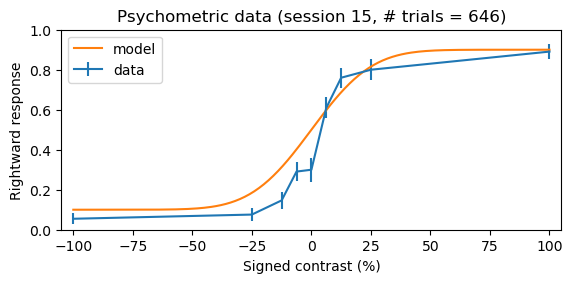

In [5]:
theta0 = (0,20,0.2,0.5) # Arbitrary parameter values - try different ones
session_num = 15
fig = plt.figure(figsize=figsize)
ax = plot_psychometric_data(df,session_num)
psychofun_plot(theta0,ax)
plt.show()

## III. Psychometric function log-likelihood

We now define the log likelihood function of the psychometric function model for a given dataset and model parameter vector, $\log p(\text{data}|\mathbf{\theta})$.

In [6]:
def psychofun_loglike(theta,df):
    """Log-likelihood for psychometric function model"""
    s_vec = df['signed_contrast'] # Stimulus values
    r_vec = df['response_choice']  # Responses
    
    p_right = psychofun(theta,s_vec)
    
    # Compute summed log likelihood for all rightwards and leftwards responses
    loglike = np.sum(np.log(p_right[r_vec == 1])) + np.sum(np.log(1 - p_right[r_vec == -1]))

    return loglike

Now try to get the best fit for this session, as we did before, but by finding better and better values of the log-likelihood.

Log-likelihood value: -305.536


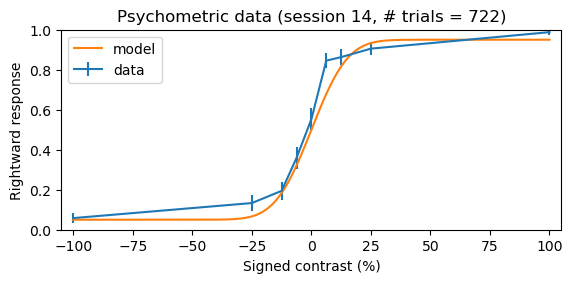

In [7]:
session_num = 14 # Let's use a different session

theta0 = (0,12,0.1,0.5) 

ll = psychofun_loglike(theta0,df[df['session_num'] == session_num])
print('Log-likelihood value: ' + "{:.3f}".format(ll))

fig = plt.figure(figsize=figsize)
ax = plot_psychometric_data(df,session_num)
psychofun_plot(theta0,ax)
plt.show()

Note that we could fit the model to the data by finding the single "best" parameter vector $\theta$ that maximizes the log-likelihood, a common technique known as *maximum-likelihood estimation*. However, we are going to go full Bayesian.

## IV. Bayesian inference "by hand"

As a first exercise, we fix the parameters of our psychometric function model except for one, and calculate a (one-dimensional) posterior distribution for the free parameter, given the other parameters. 

Here we take $\sigma$ (i.e., `sigma`) as the free parameter and fix the others.
Our goal then is to infer the 1D posterior: $$p(\sigma|\mu_\star,\lambda_\star,\gamma_\star,\mathcal{D}).$$

C:\Users\luigi\AppData\Local\Temp\ipykernel_1688\3798048102.py:46: RuntimeWarning: divide by zero encountered in log
  logpost[i] = loglike_fun(sigma) + np.log(prior_pdf[i]);    # Unnormalized


Posterior integral: 1.0


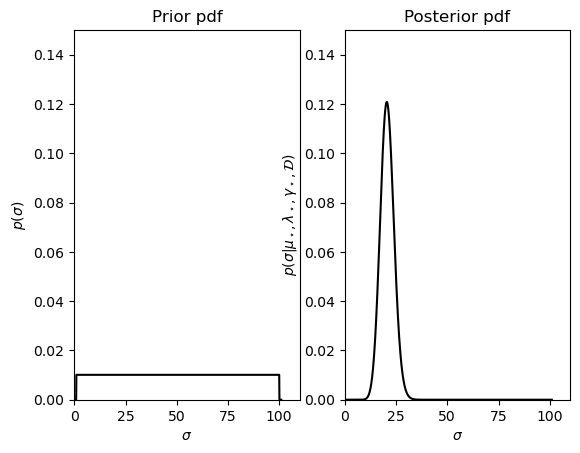

In [46]:
# Fixed parameter values (here ~ maximum-likelihood values)
mu_star = -10         # bias
lambda_star = 0.26    # lapse_rate
gamma_star = 0.54     # lapse_bias

# We define hard lower/upper bounds for sigma
lb = 1
ub = 100

# Define a grid for sigma
sigma_range = np.linspace(0.01, ub + 1, 1001)
dsigma = sigma_range[1] - sigma_range[0]   # Grid spacing

# Define the prior over sigma as a uniform box between lb and ub (0 outside)
prior_pdf = 1/(ub - lb) * ((sigma_range >= lb) & (sigma_range <= ub))

# Just to see what happens: change the prior to a (truncated) Gaussian
#prior_pdf = norm.pdf(sigma_range,5,6) * ((sigma_range >= lb) & (sigma_range <= ub));
#prior_pdf = prior_pdf / (np.sum(prior_pdf)*dsigma);   # Normalize

# Plot prior pdf
fig,ax =  plt.subplots(1,2)
ax[0].plot(sigma_range,prior_pdf,'-k')
ax[0].set_xlabel('$\sigma$')
ax[0].set_ylabel('$p(\sigma)$');
ax[0].set_title('Prior pdf');
ax[0].set_xlim([0,110]);
ax[0].set_ylim([0,0.15]);

session_num = 12 # Pick session data

loglike_fun = lambda sigma_ : psychofun_loglike(
    np.array([mu_star,sigma_,lambda_star,gamma_star]),
    df[df['session_num'] == session_num]
)

# Now we directly compute the log posterior using Bayes rule (in log space)

# Define a grid to store the log posterior
logpost = np.zeros(len(sigma_range));

# Compute log of unnormalized posterior, log (likelihood * prior), for each
# value in the grid
for i in range(len(sigma_range)):
    sigma = sigma_range[i];
    logpost[i] = loglike_fun(sigma) + np.log(prior_pdf[i]);    # Unnormalized

# Normalize log posterior
post_pdf = np.exp(logpost - np.max(logpost)) # Subtract maximum for numerical stability
post_pdf = post_pdf / np.sum(post_pdf * dsigma)      # This is a density

print('Posterior integral:', np.sum(post * dsigma)) # Should integrate to 1

# Plot posterior pdf
ax[1].plot(sigma_range,post_pdf,'-k')
ax[1].set_xlabel('$\sigma$')
ax[1].set_ylabel('$p(\sigma | \mu_\star, \lambda_\star, \gamma_\star, \mathcal{D})$');
ax[1].set_title('Posterior pdf');
ax[1].set_xlim([0,110]);
ax[1].set_ylim([0,0.15]);


## V. A closer look at the priors

To be written...

## VI. Running Bayesian inference


### PyVBMC

VBMC is an algorithm to efficiently perform Bayesian inference, and PyVBMC is its Python implementation. We recall that the goal of Bayesian inference is to obtain the *posterior distribution* $p(\theta|\mathcal{D})$  for a vector of model parameters $\theta$ and data set $\mathcal{D}$. The calculation involves [Bayes' theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem):

$$
p(\theta|\mathcal{D}) = \frac{p(\mathcal{D}|\theta) p(\theta)}{p(\mathcal{D})},
$$

where $p(\mathcal{D}|\theta)$ is the *likelihood*, $p(\theta)$ is the *prior*, and $p(\mathcal{D})$ is the normalization constant, also known as the *model evidence* or *marginal likelihood*.

VBMC takes as input the unnormalized log posterior, or log (joint) density, $\log p(\mathcal{D}|\theta) p(\theta)$ (also known as the *target*), and outputs: 
- a *variational posterior* $q(\theta|\mathcal{D})$ which is an (often very accurate) approximation of the true posterior;
- an approximate lower bound to the log marginal likelihood, called ELBO (**e**vidence **l**ower **bo**und), and an estimate of its uncertainty;

all using as few target evaluations as possible.
In the following, we see how to set up and run PyVBMC on a toy example.

### Model definition: log-likelihood, log-prior, and log-joint

The log-likelihood function $\log p(\mathcal{D}|\theta)$ depends on the model under consideration, where $\mathcal{D}$ is the data and $\theta$ is a vector of $D$ model parameters.

For this tutorial, we will use the psychometric function model defined above in Section 2, and we fit data from a specific session `session_num`.

In [8]:
# Pick session data
session_num = 14
df_session = df[df['session_num'] == session_num]

def log_likelihood(theta):
    """Log-likelihood of the psychometric model (for a given session or dataset)."""
    return psychofun_loglike(theta,df_session)

We define then a prior $p(\theta)$ over the parameters. For simplicity, we set an independent uniform box prior on each variable, but you could use any prior of your choice. Note that PyVBMC uses the logarithm of the prior, $\log p(\theta)$. 

Since in this example the priors for each variable are independent, we compute the log-prior separately for each variable and then sum them:

$$
\log p(\theta) = \log \prod_{d = 1}^{D} p(\theta_d) = \sum_{d = 1}^{D} \log p(\theta_d).
$$

The uniform box prior is constant within an interval `lb` (lower bound) and `ub` (upper bound), and zero otherwise.

In [9]:
# Define hard parameter bounds
lb = np.array([-100,1,0,0])
ub = np.array([100,100,1,1])

def log_prior(theta):
    """Uniform box prior."""
    if np.any(theta0 < lb) | np.any(theta0 > ub):
        return -np.inf # Outside the box    
    else:
        return np.sum(np.log(ub - lb))

Finally, by default PyVBMC assumes that the provided `target` function is the log-joint, or unnormalized log posterior, defined as:

$$
\log p(\mathcal{D}, \theta) = \log p(\mathcal{D}| \theta) p(\theta) = \log p(\mathcal{D}| \theta) + \log p(\theta).
$$

In [10]:
def log_joint(theta):
    """Log-density of the joint distribution."""
    return log_likelihood(theta) + log_prior(theta)

### Initialize and run inference

PyVBMC requires the user to specify so-called *plausible bounds* which should denote a region of high posterior probability mass. The plausible range is used to initialize some hyperparameters of the inference algorithm and guide the initial exploration of the posterior landscape, but it does not otherwise affect the model (although a good choice of plausible range can considerably improve convergence of the algorithm).

We define the plausible bounds `plb` and `pub` based on our knowledge from typical experiments.

In [11]:
from pyvbmc import VBMC

# Define plausible range
plb = np.array([-25,5,0.05,0.2])
pub = np.array([25,25,0.40,0.8])

D = len(lb) # number of parameters

As a starting point $\theta_0$ for the algorithm we randomly draw a point from inside the plausible range:

In [12]:
theta0 = plb + np.random.uniform(size=(1,D))*(pub - plb)

We now initialize the `vbmc` object which takes care of the inference. We use the default options, specifying to show plots of the posterior at each iteration.

In [13]:
options = {"plot": True}
vbmc = VBMC(log_joint, theta0, lb, ub, plb, pub, options)

Reshaping lower bounds to (1, 4).
Reshaping upper bounds to (1, 4).
Reshaping plausible lower bounds to (1, 4).
Reshaping plausible upper bounds to (1, 4).
Casting lower bounds to floating point.
Casting upper bounds to floating point.


To perform inference, we now run `vbmc.optimize()`. The algorithm returns the variational posterior `vp` and a `results` dictionary containing additional information about the optimization.

Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10        -301.63        18.63          inf        2        inf     start warm-up


C:\Users\luigi\anaconda3\envs\nyu2023-bayes\lib\site-packages\pyvbmc\stats\kl_div_mvn.py:37: RuntimeWarning: divide by zero encountered in log
  lndet = np.log(detq2 / detq1)


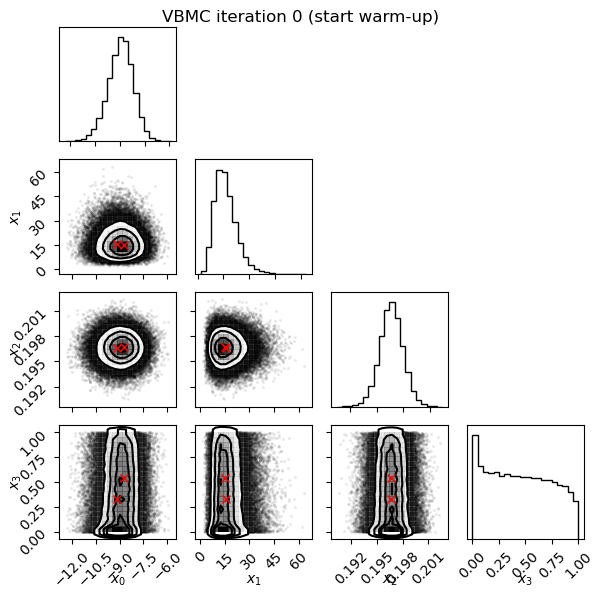

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     1         15        -302.29        10.75       115.62        2        inf     


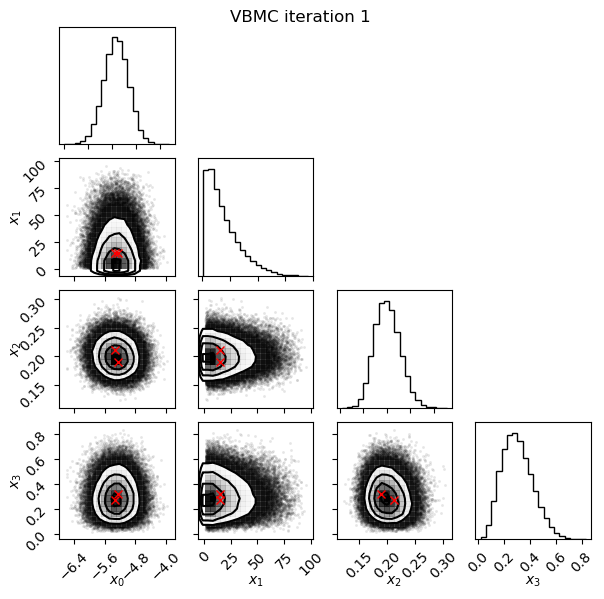

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     2         20        -289.20        15.25       565.30        2   9.52e+03     


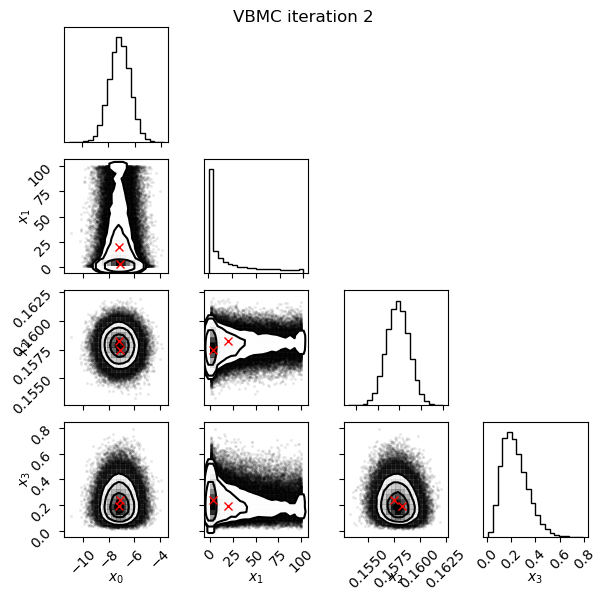

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     3         25        -290.06        18.19       577.91        2    9.7e+03     


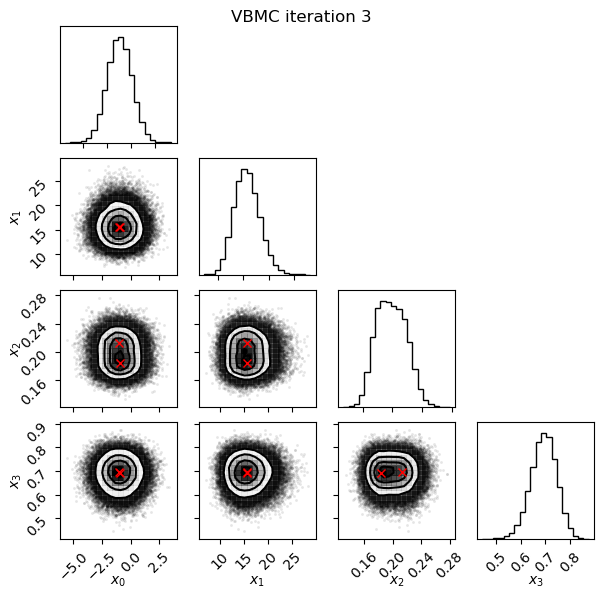

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     4         30        -294.28         1.84        16.72        2        299     


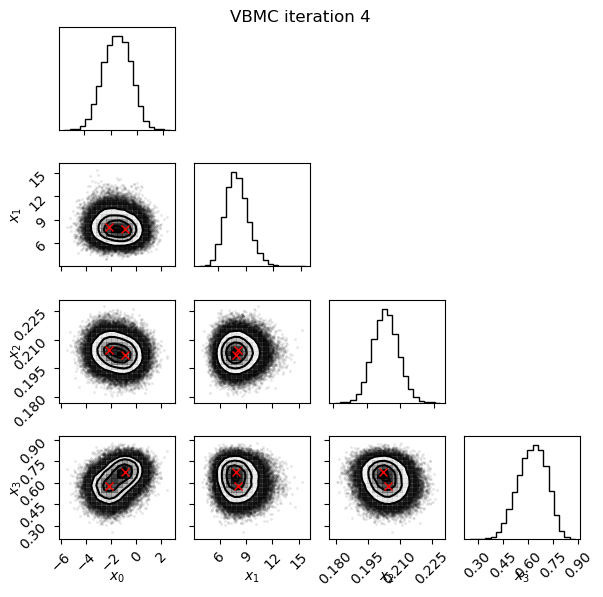

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     5         35        -291.72         0.75        19.33        2        333     


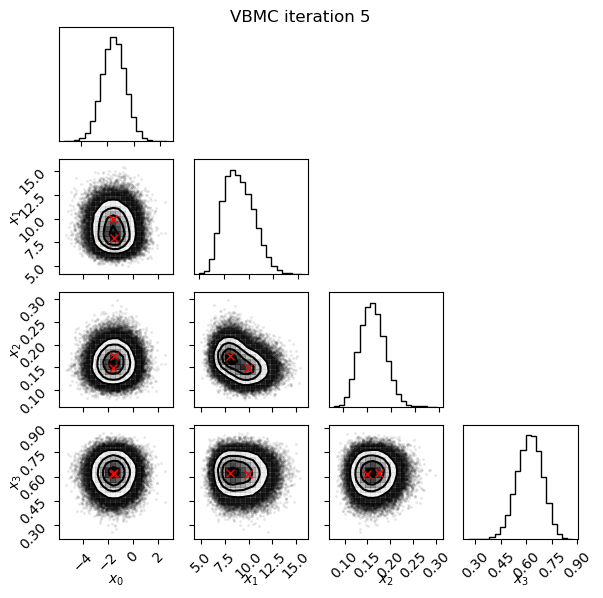

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     6         40        -291.13         0.06         0.49        2       10.4     


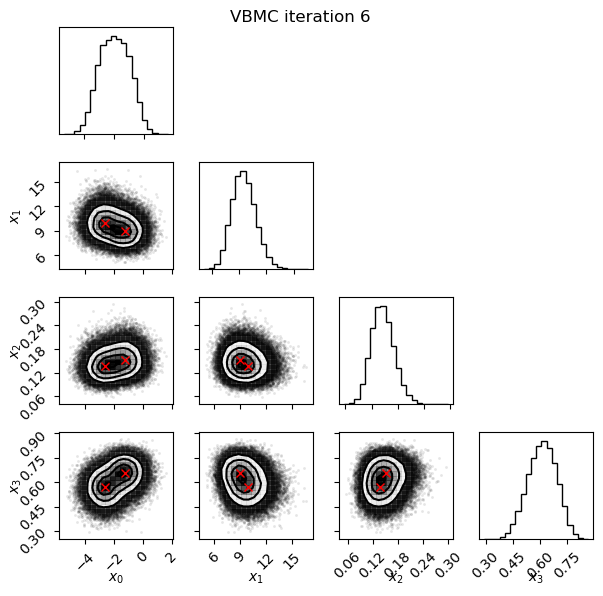

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     7         45        -291.03         0.06         0.29        2       5.47     


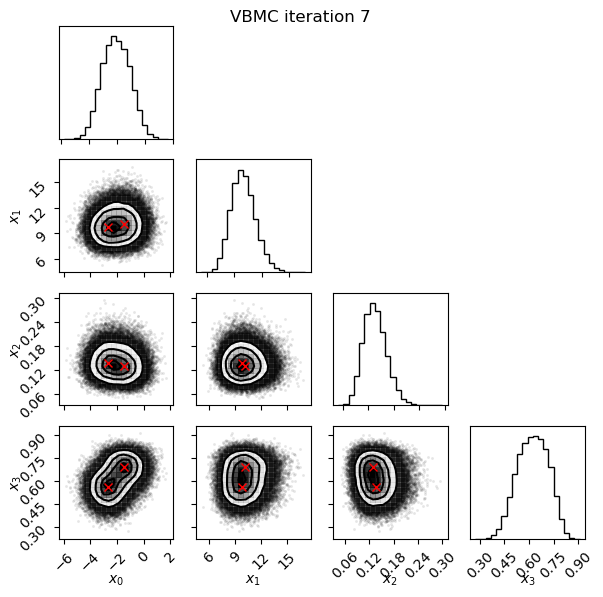

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     8         50        -290.99         0.03         0.36        2       6.16     


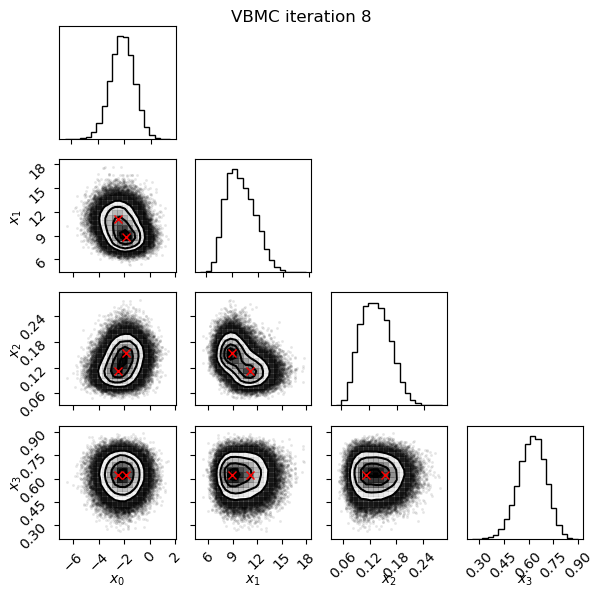

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     9         55        -290.85         0.01         0.03        2       0.99     


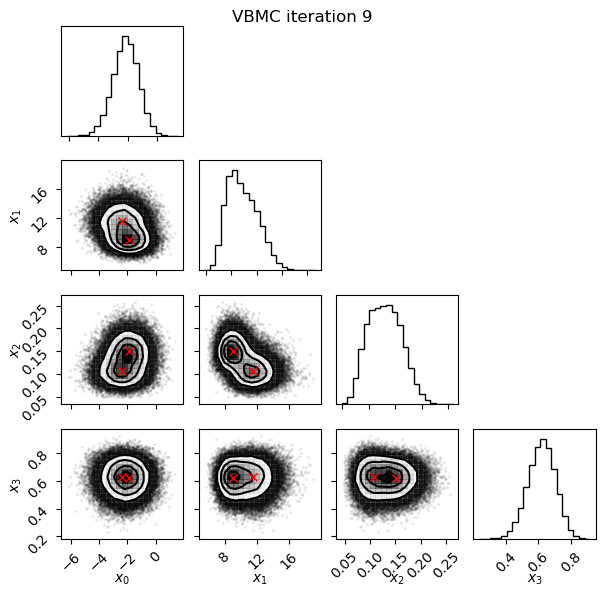

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
    10         60        -290.88         0.01         0.02        2      0.504     


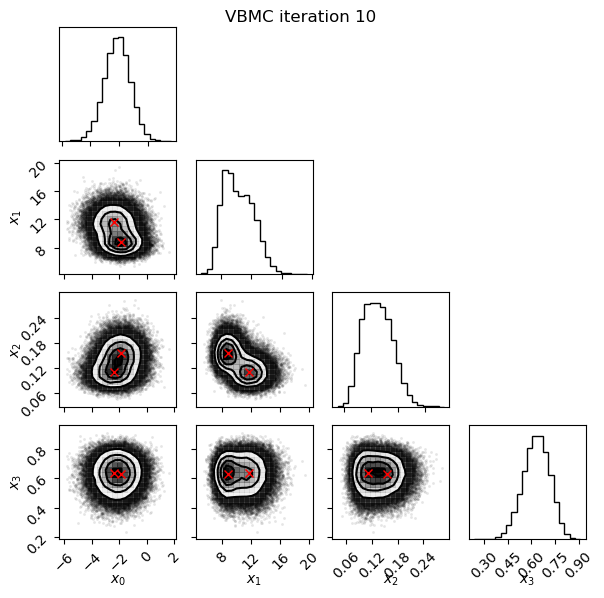

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
    11         65        -290.86         0.01         0.02        2      0.473     end warm-up


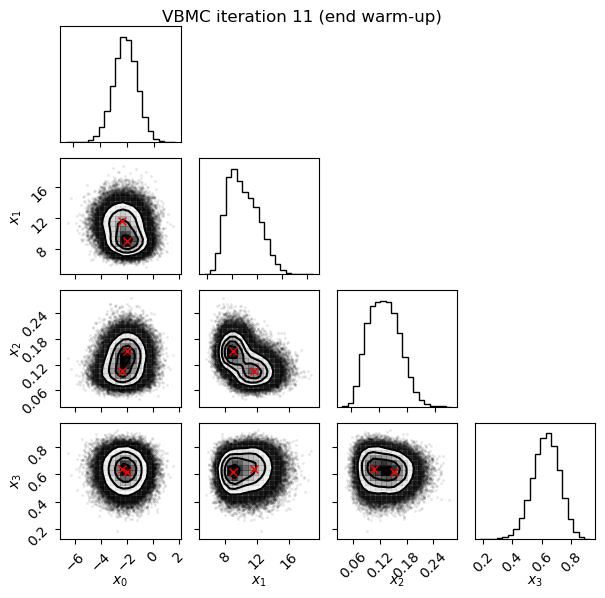

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
    12         70        -290.84         0.01         0.01        2      0.198     


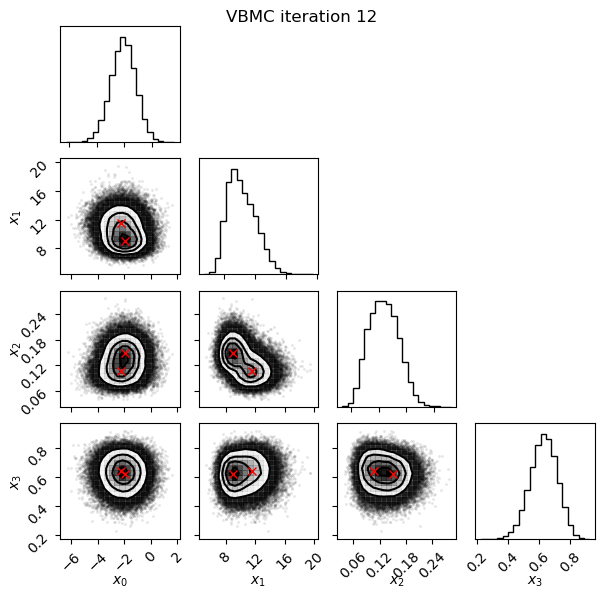

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
    13         75        -290.88         0.01         0.01        2      0.279     


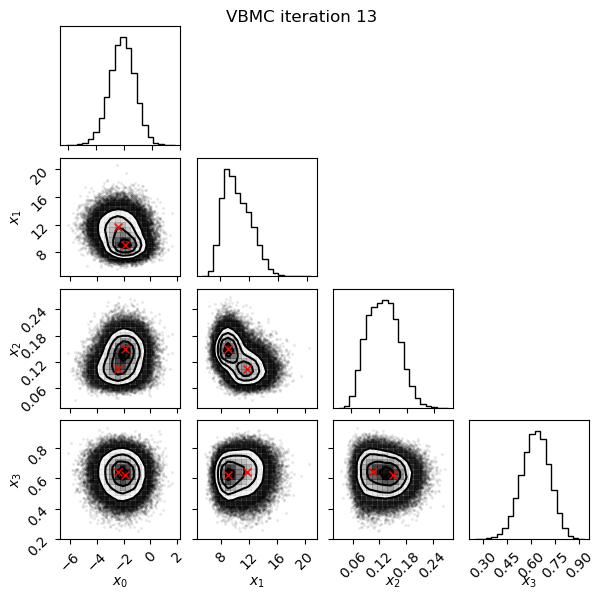

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
    14         80        -290.65         0.01         0.10        5       2.46     


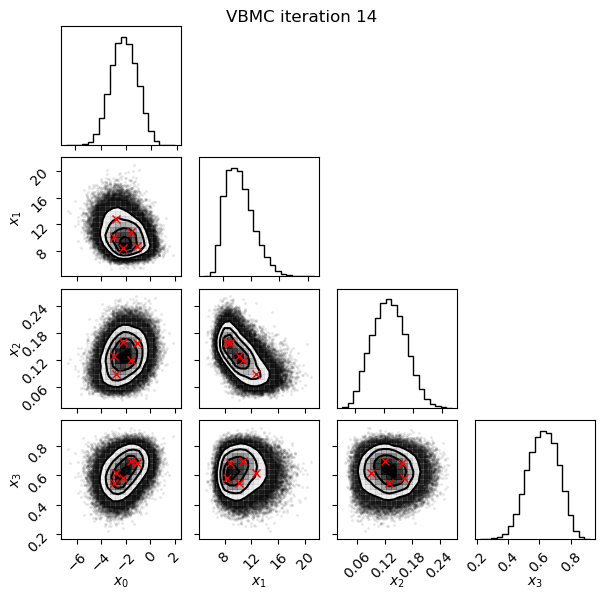

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
    15         85        -290.65         0.00         0.01        6      0.185     rotoscale, undo rotoscale


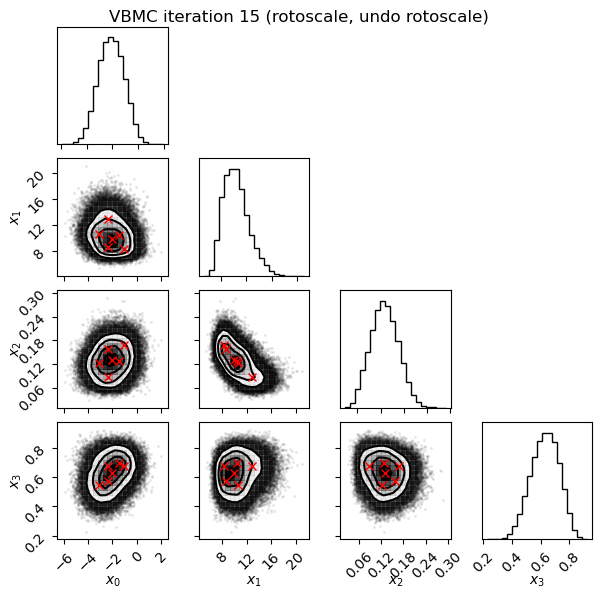

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
    16         90        -290.63         0.01         0.00        6      0.143     


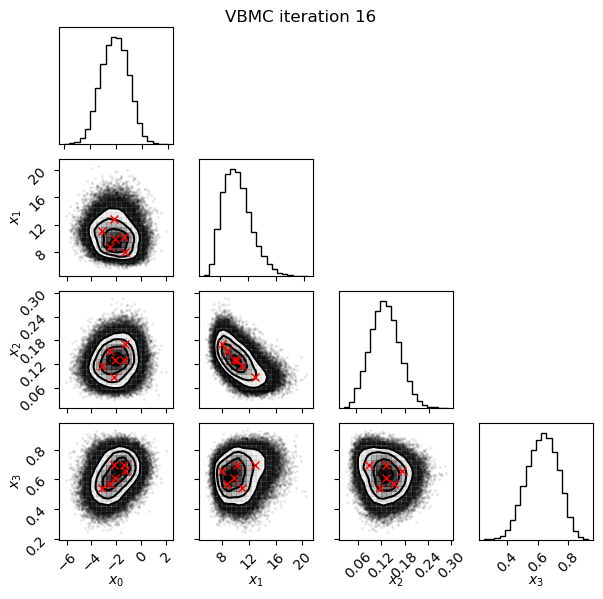

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
    17         95        -290.62         0.00         0.01        9      0.148     


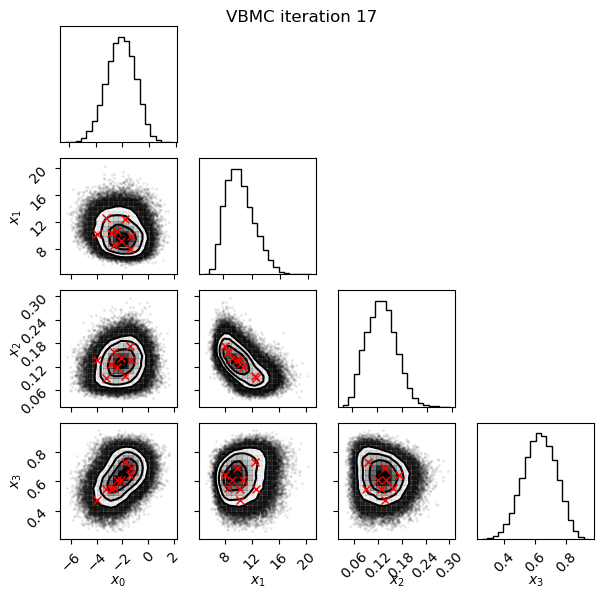

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
    18        100        -290.59         0.00         0.00       12      0.126     


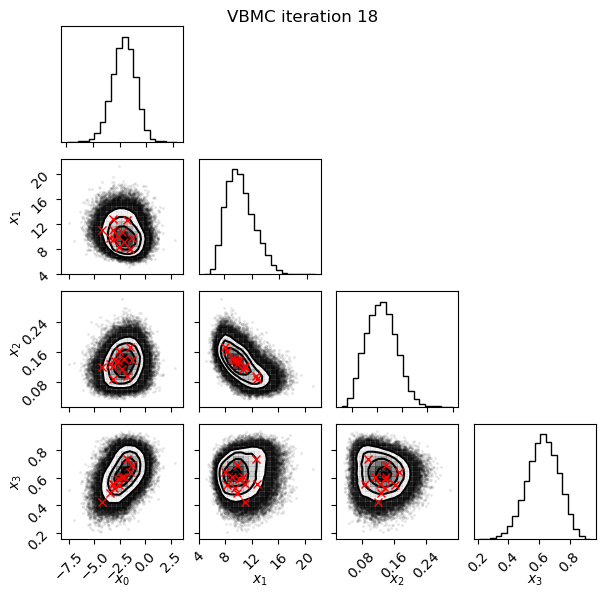

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
    19        105        -290.58         0.00         0.00       15     0.0835     stable


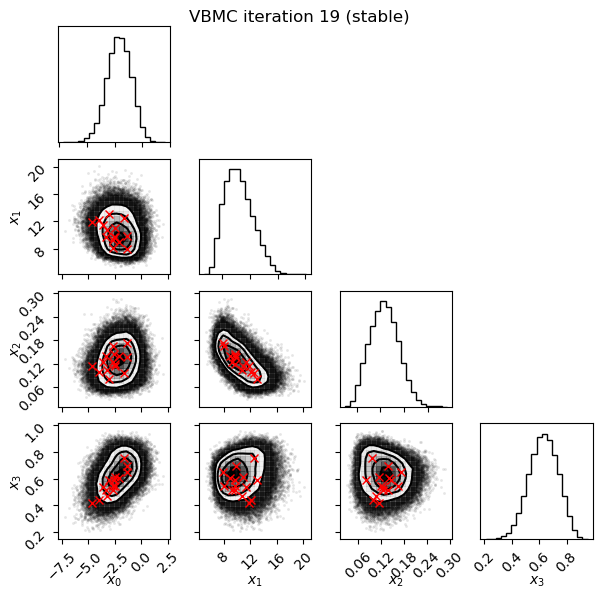

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
   inf        105        -290.54         0.00         0.02       50     0.0835     finalize


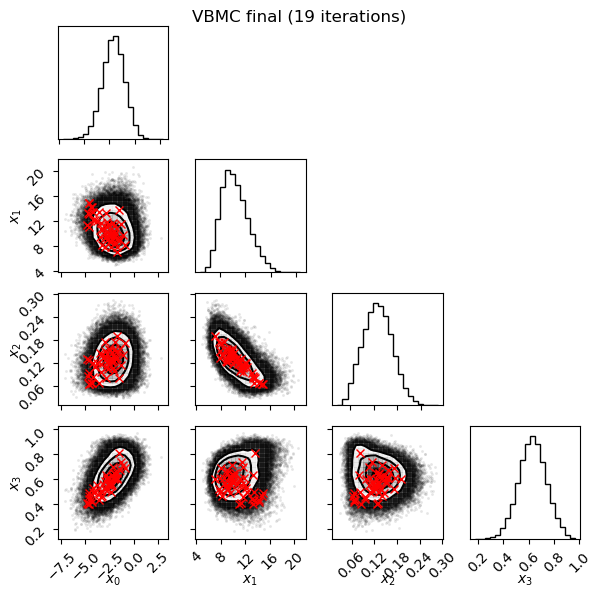

Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -290.543 +/-0.005.


In [14]:
vp, results = vbmc.optimize()

## VII. Posterior usages: visualization, uncertainty, prediction

We now examine the obtained variational posterior. We can easily draw hundreds of thousands of random samples from the variational posterior to compute summary statistics of interests.

For reporting uncertainty on model parameter estimates, you could use posterior mean +/- SD, or the median and interquartile range of the samples (the latter is better for a posterior that deviates substantially from Gaussian).

In [15]:
# First, generate a large number of samples from the variational posterior:
n_samples = int(1e5)
theta_s, _ = vp.sample(n_samples)

# Easily compute statistics such as moments, credible intervals, etc.
post_mean = np.mean(theta_s, axis=0)  # Posterior mean
post_cov = np.cov(theta_s.T)  # Posterior covariance matrix
print("The approximate posterior mean is:", post_mean)
print("The approximate posterior covariance matrix is:\n", post_cov)

The approximate posterior mean is: [-2.13794365 10.44740598  0.12922286  0.63080339]
The approximate posterior covariance matrix is:
 [[ 1.18492719e+00 -3.43664341e-01  6.36775902e-03  5.57153122e-02]
 [-3.43664341e-01  4.40036590e+00 -5.32351970e-02  4.86940028e-02]
 [ 6.36775902e-03 -5.32351970e-02  1.35183372e-03 -5.66595820e-04]
 [ 5.57153122e-02  4.86940028e-02 -5.66595820e-04  1.18749880e-02]]


We visualize the obtained variational approximation vp via the `vp.plot()` function.

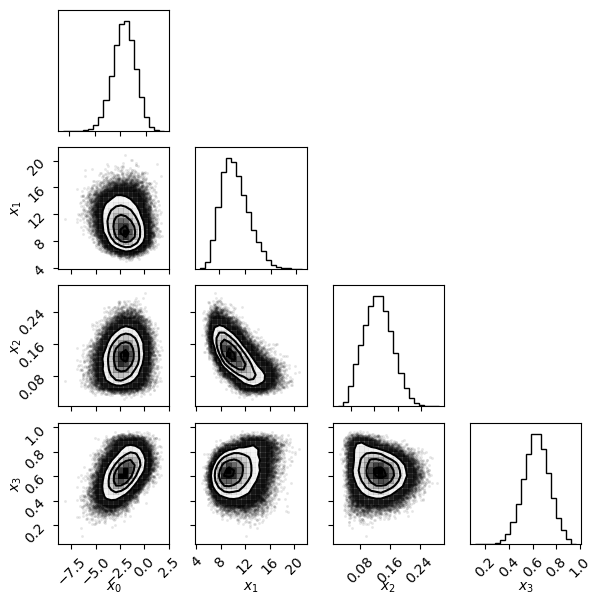

In [16]:
vp.plot();

Finally, we plot posterior predictions (the "Bayesian fit"), also known as *posterior predictive check* (we check that our fit matches the data!).

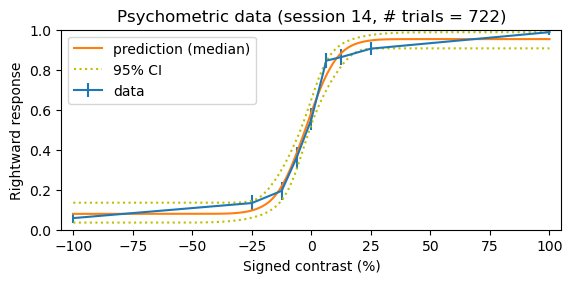

In [17]:
n_samples = int(1e4)
theta_s, _ = vp.sample(n_samples)

fig = plt.figure(figsize=figsize)
ax = plot_psychometric_data(df,session_num)

# Compute psychometric function values for each sample
stim = np.linspace(-100,100,201)  
p_right = np.zeros((n_samples,len(stim))) 
for i in range(n_samples):
    p_right[i,:] = psychofun(theta_s[i,:],stim)

median_pred = np.quantile(p_right,0.5,0)     # Median prediction
bottom_pred = np.quantile(p_right,0.025,0)   # Bottom 2.5% prediction
top_pred = np.quantile(p_right,0.975,0)      # Top 97.5% prediction

ax.plot(stim,median_pred,label='prediction (median)')
ax.plot(stim,bottom_pred,':y',label='95% CI')
ax.plot(stim,top_pred,':y')

plt.legend()
plt.show()

## Conclusions

In this tutorial, we have seen how to set up and run Bayesian inference with PyVBMC for a real (if simple) model and data used in cognitive science and neuroscience.

For further information on PyVBMC and more example usages, see [the PyVBMC documentation](https://acerbilab.github.io/pyvbmc/).

### Acknowledgments

Work on the PyVBMC package was funded by the [Finnish Center for Artificial Intelligence FCAI](https://fcai.fi/).